In [22]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import glob
from collections import namedtuple, OrderedDict
import netCDF4 as nc
import os
import scipy
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools
import gsw
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Ellipse
import matplotlib as mpl

import seaborn as sns
from windrose import plot_windrose
from windrose import WindroseAxes


from dateutil        import parser
from datetime import datetime

import numpy.ma as ma

sns.set_context('talk')
sns.set_style('darkgrid')

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
sns.set_context('poster')
sns.set_style('darkgrid')

In [3]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



nc_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/accurate_isopycnals_eddy_water_particles_two_months_more.nc')
nc_tools.show_variables(nc_file)

odict_keys(['init_x', 'init_y', 'init_z', 'init_t', 'init_age', 'init_transp', 'final_x', 'final_y', 'final_z', 'final_t', 'final_age', 'final_transp', 'traj_lon', 'traj_lat', 'traj_depth', 'traj_time', 'traj_temp', 'traj_salt', 'traj_dens'])


In [4]:


init_x = nc_file.variables['init_x']
init_z = nc_file.variables['init_z']
init_age = nc_file.variables['init_age']

traj_depth = nc_file.variables['traj_depth'][:]
traj_lon   = nc_file.variables['traj_lon'][:]
traj_lat   = nc_file.variables['traj_lat'][:]
traj_rho   = nc_file.variables['traj_dens'][:]
traj_tem   = nc_file.variables['traj_temp'][:]
traj_sal   = nc_file.variables['traj_salt'][:]
traj_time  = nc_file.variables['traj_time']


final_age = nc_file.variables['final_age']


# lon1=nc_file.variables['traj_lon'][:]
# lat1=nc_file.variables['traj_lat'][:]
# dep1=nc_file.variables['traj_depth'][:]
x1=nc_file.variables['init_x'][:]
y1=nc_file.variables['init_y'][:]
t1=nc_file.variables['traj_time'][:]

x_low = x1
y_low = y1

x2=nc_file.variables['final_x'][:]
y2=nc_file.variables['final_y'][:]


final_z = nc_file.variables['final_z'][:]

final_age_days = final_age[:]/(3600)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [5]:
x_final = []
y_final = []


for i in np.arange(x2.shape[0]):
    x_final = np.append(arr=x_final,values=x_wcvi_slice[np.int(np.rint(x2[i]))-1])
    y_final = np.append(arr=y_final,values=y_wcvi_slice[np.int(np.rint(y2[i]))-1])

In [6]:
def plot_particle_track(particle_ind):
    
    part = particle_ind
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]



    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon_small = file_model.variables['nav_lon'][1:,1:]
    lat_small = file_model.variables['nav_lat'][1:,1:]




#     cmap=plt.cm.get_cmap('nipy_spectral')
    cmap = plt.cm.get_cmap('gist_rainbow_r')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # part = ind[0]
    # for part in ind[139]:

    for k in np.arange(0,np.int(final_age_days[part]),10):
        y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
        q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

        t = np.int(np.rint(120 - traj_time[k,part]*120))
        level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



        j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                                  lon_small,lat_small,grid='NEMO',tols=\
                                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


    #     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
    # #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    # ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    ax.grid()

    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()

    
def plot_combined_particle_track_one_month(particle_ind):
    
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]



    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon_small = file_model.variables['nav_lon'][1:,1:]
    lat_small = file_model.variables['nav_lat'][1:,1:]




#     cmap=plt.cm.get_cmap('nipy_spectral')
    cmap = plt.cm.get_cmap('gist_rainbow_r')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # part = ind[0]
    # for part in ind[139]:
    
    for part in particle_ind:

        for k in np.arange(0,np.int(final_age_days[part]),10):
            y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
            track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
            q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=10, alpha=0.9)#, edgecolor= 'k')

            t = np.int(np.rint(120 - traj_time[k,part]*120))
            level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



#             j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
#                                                       lon_small,lat_small,grid='NEMO',tols=\
#                                                       {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
#                                                        'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


    #     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
    # #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    # ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    ax.grid()

    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()
    
    
def plot_particle_track_one_month_from_source(particle_ind):
    
    part = particle_ind
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]



    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon_small = file_model.variables['nav_lon'][1:,1:]
    lat_small = file_model.variables['nav_lat'][1:,1:]




#     cmap=plt.cm.get_cmap('nipy_spectral')
    cmap = plt.cm.get_cmap('gist_rainbow_r')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # part = ind[0]
    # for part in ind[139]:

    for k in np.arange(2136,np.int(final_age_days[part]),10):
        y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
        q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

        t = np.int(np.rint(120 - traj_time[k,part]*120))
        level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



        j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                                  lon_small,lat_small,grid='NEMO',tols=\
                                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


    #     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
    # #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    # ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    ax.grid()

    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()
    
    
    
    
def plot_pie_diagram(off_percentage, south_percentage, cuc_percentage, juan_percentage, north_percentage):

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]




    cmap=plt.cm.get_cmap('nipy_spectral')
    #     cmap = plt.cm.get_cmap('gist_rainbow')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)
    for k in np.arange(x1.shape[0]):
        ax.scatter(x_wcvi_slice[np.int(x1[k]-1)],y_wcvi_slice[np.int(y1[k]-1)], marker = '*', c = 'red', s = 10, linewidths=3)
    

    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    x = [520,575]
    y = [320,200]
    ax.plot(x, y , 'bo-')


    ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
    ax.hlines(y = 320, xmin = 520, xmax=590, color = 'b')
    ax.grid()

    axins = inset_axes(ax, width="50%", height="75%",
                       bbox_to_anchor=(.085, .15, .5, .5),
                       bbox_transform=ax.transAxes, loc=3)
    axins.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    axins.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)


    labels = 'Offshore', 'From South', 'CUC','Strait outflow', 'From North', 'Local water'
    sizes = [off_percentage, south_percentage, cuc_percentage, juan_percentage, north_percentage, \
             100- (off_percentage + south_percentage + cuc_percentage + juan_percentage + north_percentage)]
    explode = (0, 0.1, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')


    size = 0.35
    vals = np.array([[9.5, 0], [10.2, 0], [12.3, 0], [25.4, 51.7-25.4]])

    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(4)*4)
    inner_colors = cmap(np.arange(5)*4)#cmap(np.array([1, 4, 7, 10, 13, 25]))

    axins.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    axins.axis('equal') 
    ax.vlines(x = 648, ymin = 255, ymax = 271, color = 'blue')

    fig.tight_layout()
    
    
def get_cov_ellipse(cov, centre, nstd, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)


def find_index(k):
    
    indice = np.zeros(final_age.shape[0])
    
    for m in np.arange(traj_lon.shape[1]):

        y, x = geo_tools.find_closest_model_point(traj_lon[k,m],traj_lat[k,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        y1,x1 = geo_tools.find_closest_model_point(traj_lon[k-500,m],traj_lat[k-500,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

        bbox = mpl.transforms.Bbox(points=[(x,y), (x1,y1)]) 

        if (mpl.path.Path(vertices=vert).intersects_bbox(bbox, filled=True)) == True:
            
            indice[m] = m

        else:
            continue

    indexes = np.array(np.nonzero(indice))
    
    return indexes[0]


def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)
    return ax


def mixing(T, S, inds):
    """
    Compute the water mass mixing percentage using Mamayev's (1975) mixing
    triangle.

    Parameters
    ----------
    T : Conservative Temperature
    S : Absolute Salinity
    inds :  2x3 array with thermohaline indices
            [T1 T2 T3
            S1 S2 S3]

    Returns
    -------
    m1, m2, m3 : Water mass percentage for masses 1, 2 e 3.

    """

    a = np.r_[inds, np.ones((1, 3))]
    b = np.c_[T.ravel(), S.ravel(), np.ones(T.shape).ravel()].T
    m = np.linalg.solve(a, b)
    m1 = m[0].reshape(T.shape)
    m2 = m[1].reshape(T.shape)
    m3 = m[2].reshape(T.shape)

    # Mask values outside mixing triangle.
    m1 = ma.masked_outside(ma.masked_invalid(m1), 0, 1)
    m2 = ma.masked_outside(ma.masked_invalid(m2), 0, 1)
    m3 = ma.masked_outside(ma.masked_invalid(m3), 0, 1)

    m1 = 100 * m1
    m2 = 100 * m2
    m3 = 100 * m3
    return m1, m2, m3


In [7]:
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

p1= (x[0],y[0])
p1 = np.asarray(p1)
p2 = (x[1], y[1])
p2 = np.asarray(p2)



d = np.empty_like(x_final)

off_ind = []


for r in np.arange(x_final.shape[0]):

    p3 = (x_final[r], y_final[r])
    p3 = np.asarray(p3)
    d[r] =np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
    
    if ((d[r] < 0) & (x_final[r] < 575)):
        off_ind = np.append(arr=off_ind, values=np.int(r))

In [8]:
num_north = np.round(a=final_age[(x_final < 580) & (y_final > 300)].shape[0]/final_z.shape[0], decimals=3)

north_percent = 100*num_north

print(north_percent)

num_cuc = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]>26.3)[0].shape[0]/final_z.shape[0], decimals = 3)

cuc_percent = 100*num_cuc

print(cuc_percent)

num_south = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]<=26.3)[0].shape[0]/final_z.shape[0], decimals = 3)

south_percent = 100*num_south

print(south_percent)

### Bigger box
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

num_off = off_ind.shape[0]/final_z.shape[0]
off_percent = np.round(a=100*num_off, decimals=1)

print(off_percent)

num_juan = np.round(a=np.where((x_final > 648))[0].shape[0]/final_z.shape[0], decimals=3)

juan_percent = num_juan*100

print(juan_percent)

5.2
42.0
22.5
21.4
2.4


In [9]:
cuc_percent_low = cuc_percent
juan_percent_low = juan_percent
north_percent_low = north_percent
south_percent_low = south_percent
off_percent_low = off_percent



In [10]:
traj_tem_last   = np.empty_like(final_age_days)
traj_sal_last   = np.empty_like(final_age_days)
traj_rho_last   = np.empty_like(final_age_days)
traj_depth_last = np.empty_like(final_age_days)


traj_tem_init   = np.empty_like(final_age_days)
traj_sal_init   = np.empty_like(final_age_days)
traj_rho_init   = np.empty_like(final_age_days)
traj_depth_init = np.empty_like(final_age_days)

for r in np.arange(traj_tem_last.shape[0]):
    traj_tem_last[r]  =  traj_tem[np.int(final_age_days[r]),r]
    traj_sal_last[r]  =  traj_sal[np.int(final_age_days[r]),r]
    traj_rho_last[r]  =  traj_rho[np.int(final_age_days[r]),r]
    traj_depth_last[r] = traj_depth[np.int(final_age_days[r]),r]
    
    traj_tem_init[r]  =  traj_tem[0,r]
    traj_sal_init[r]  =  traj_sal[0,r]
    traj_rho_init[r]  =  traj_rho[0,r]    
    traj_depth_init[r]=  traj_depth[0,r] 
    

In [11]:
max_life_ind = np.array(np.where(final_age_days == np.max(final_age_days))[0])

off_ind   = off_ind
north_ind = np.where([(x_final < 580) & (y_final > 300)])[1]
south_ind = []
cuc_ind   = []


ind_all_south  = np.where(((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200)))[0]

for k in ind_all_south:
    if final_z[k] <= 26.3:
        south_ind = np.append(arr=south_ind, values= k)
        
    if final_z[k] > 26.3:
        cuc_ind = np.append(arr=cuc_ind, values=k)
        

juan_ind =  np.where((x_final > 648))[0]

non_local_ind = np.concatenate((off_ind, north_ind, south_ind, cuc_ind, juan_ind))

ind_local = np.setdiff1d(max_life_ind, np.unique(non_local_ind, return_index= False).astype(int), assume_unique=True)

# off_ind/

# ind_local = np.setdiff1d(max_life_ind, off_ind, assume_unique= True)

x_local_low_actual = x2[ind_local]
y_local_low_actual = y2[ind_local]

depth_local_low_actual = -traj_depth_last[ind_local]


In [12]:
count_ind = np.concatenate((ind_local, np.unique(non_local_ind, return_index= False).astype(int)))

count_ind.shape[0]/final_z.shape[0]

0.989501312335958

In [13]:

traj_tem_final_cuc = traj_tem_last[cuc_ind.astype(int)]
traj_sal_final_cuc = traj_sal_last[cuc_ind.astype(int)]
traj_rho_final_cuc = traj_rho_last[cuc_ind.astype(int)]
traj_depth_final_cuc = traj_depth_last[cuc_ind.astype(int)]
traj_days_final_cuc = final_age_days[cuc_ind.astype(int)]/24



traj_tem_final_north = traj_tem_last[north_ind.astype(int)]
traj_sal_final_north = traj_sal_last[north_ind.astype(int)]
traj_rho_final_north = traj_rho_last[north_ind.astype(int)]
traj_depth_final_north = traj_depth_last[north_ind.astype(int)]
traj_days_final_north = final_age_days[north_ind.astype(int)]/24



traj_tem_final_south   = traj_tem_last[south_ind.astype(int)]
traj_sal_final_south   = traj_sal_last[south_ind.astype(int)]
traj_rho_final_south   = traj_rho_last[south_ind.astype(int)]
traj_depth_final_south = traj_depth_last[south_ind.astype(int)]
traj_days_final_south  = final_age_days[south_ind.astype(int)]/24


traj_tem_final_juan = traj_tem_last[juan_ind.astype(int)]
traj_sal_final_juan = traj_sal_last[juan_ind.astype(int)]
traj_rho_final_juan = traj_rho_last[juan_ind.astype(int)]
traj_depth_final_juan = traj_depth_last[juan_ind.astype(int)]
traj_days_final_juan = final_age_days[juan_ind.astype(int)]/24


traj_tem_final_local = traj_tem_last[ind_local.astype(int)]
traj_sal_final_local = traj_sal_last[ind_local.astype(int)]
traj_rho_final_local = traj_rho_last[ind_local.astype(int)]
traj_depth_final_local = traj_depth_last[ind_local.astype(int)]
traj_days_final_local = final_age_days[ind_local.astype(int)]/24




x = [510,575]
y = [320,200]

coefficients = np.polyfit(x, y, 1)
x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

traj_tem_final_off = []
traj_sal_final_off = []
traj_rho_final_off = []
traj_depth_final_off = []
traj_days_final_off = []

for l in np.arange(off_ind.shape[0]):

    traj_depth_final_off = np.append(arr=traj_depth_final_off, values=traj_depth_last[np.int(off_ind[l])])
    traj_days_final_off = np.append(arr=traj_days_final_off, values=final_age_days[np.int(off_ind[l])]/24)
    traj_rho_final_off   = np.append(arr=traj_rho_final_off, values=traj_rho_last[np.int(off_ind[l])])
    traj_tem_final_off   = np.append(arr=traj_tem_final_off, values=traj_tem_last[np.int(off_ind[l])])
    traj_sal_final_off   = np.append(arr=traj_sal_final_off, values=traj_sal_last[np.int(off_ind[l])])


In [14]:
pressure_loc_cuc = np.empty_like(traj_depth_final_cuc)
SA_loc_cuc       = np.empty_like(traj_depth_final_cuc)
CT_loc_cuc       = np.empty_like(traj_depth_final_cuc)
spic_loc_cuc     = np.empty_like(traj_depth_final_cuc)



for i in np.arange(traj_depth_final_cuc.shape[0]):
    
    pressure_loc_cuc[i] = gsw.p_from_z(traj_depth_final_cuc[i],np.mean(traj_lat))
    
    SA_loc_cuc[i] = gsw.SA_from_SP(traj_sal_final_cuc[i], pressure_loc_cuc[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_cuc[i] = gsw.CT_from_pt(traj_sal_final_cuc[i], traj_tem_final_cuc[i])
    
    spic_loc_cuc[i] = gsw.spiciness0(SA_loc_cuc[i], CT_loc_cuc[i])
    
pressure_loc_off = np.empty_like(traj_depth_final_off)
SA_loc_off       = np.empty_like(traj_depth_final_off)
CT_loc_off       = np.empty_like(traj_depth_final_off)
spic_loc_off     = np.empty_like(traj_depth_final_off)



for i in np.arange(traj_depth_final_off.shape[0]):
    
    pressure_loc_off[i] = gsw.p_from_z(traj_depth_final_off[i],np.mean(traj_lat))
    
    SA_loc_off[i] = gsw.SA_from_SP(traj_sal_final_off[i], pressure_loc_off[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_off[i] = gsw.CT_from_pt(traj_sal_final_off[i], traj_tem_final_off[i])
    
    spic_loc_off[i] = gsw.spiciness0(SA_loc_off[i], CT_loc_off[i])
    
pressure_loc_south = np.empty_like(traj_depth_final_south)
SA_loc_south       = np.empty_like(traj_depth_final_south)
CT_loc_south       = np.empty_like(traj_depth_final_south)
spic_loc_south     = np.empty_like(traj_depth_final_south)



for i in np.arange(traj_depth_final_south.shape[0]):
    
    pressure_loc_south[i] = gsw.p_from_z(traj_depth_final_south[i],np.mean(traj_lat))
    
    SA_loc_south[i] = gsw.SA_from_SP(traj_sal_final_south[i], pressure_loc_south[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_south[i] = gsw.CT_from_pt(traj_sal_final_south[i], traj_tem_final_south[i])
    
    spic_loc_south[i] = gsw.spiciness0(SA_loc_south[i], CT_loc_south[i])
    
pressure_loc_north= np.empty_like(traj_depth_final_north)
SA_loc_north       = np.empty_like(traj_depth_final_north)
CT_loc_north       = np.empty_like(traj_depth_final_north)
spic_loc_north     = np.empty_like(traj_depth_final_north)



for i in np.arange(traj_depth_final_north.shape[0]):
    
    pressure_loc_north[i] = gsw.p_from_z(traj_depth_final_north[i],np.mean(traj_lat))
    
    SA_loc_north[i] = gsw.SA_from_SP(traj_sal_final_north[i], pressure_loc_north[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_north[i] = gsw.CT_from_pt(traj_sal_final_north[i], traj_tem_final_north[i])
    
    spic_loc_north[i] = gsw.spiciness0(SA_loc_north[i], CT_loc_north[i])
    

pressure_loc_juan= np.empty_like(traj_depth_final_juan)
SA_loc_juan       = np.empty_like(traj_depth_final_juan)
CT_loc_juan       = np.empty_like(traj_depth_final_juan)
spic_loc_juan     = np.empty_like(traj_depth_final_juan)



for i in np.arange(traj_depth_final_juan.shape[0]):
    
    pressure_loc_juan[i] = gsw.p_from_z(traj_depth_final_juan[i],np.mean(traj_lat))
    
    SA_loc_juan[i] = gsw.SA_from_SP(traj_sal_final_juan[i], pressure_loc_juan[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_juan[i] = gsw.CT_from_pt(traj_sal_final_juan[i], traj_tem_final_juan[i])
    
    spic_loc_juan[i] = gsw.spiciness0(SA_loc_juan[i], CT_loc_juan[i])
    

In [15]:
x_plot_cuc = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/x_cuc_eddy_water_points.npy')
y_plot_cuc = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/y_cuc_eddy_water_points.npy')

x_plot_south = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/x_south_eddy_water_points.npy')
y_plot_south = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/y_south_eddy_water_points.npy')

x_plot_local = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/x_local_eddy_water_points.npy')
y_plot_local = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/y_local_eddy_water_points.npy')

x_plot_off = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/x_off_eddy_water_points.npy')
y_plot_off = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/y_off_eddy_water_points.npy')

x_plot_north = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/x_north_eddy_water_points.npy')
y_plot_north = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/y_north_eddy_water_points.npy')

x_plot_juan = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/x_juan_eddy_water_points.npy')
y_plot_juan = np.load('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/y_juan_eddy_water_points.npy')

In [16]:
sns.set_context('paper')
sns.set_style('darkgrid')

In [18]:
from scipy.interpolate import interpn

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


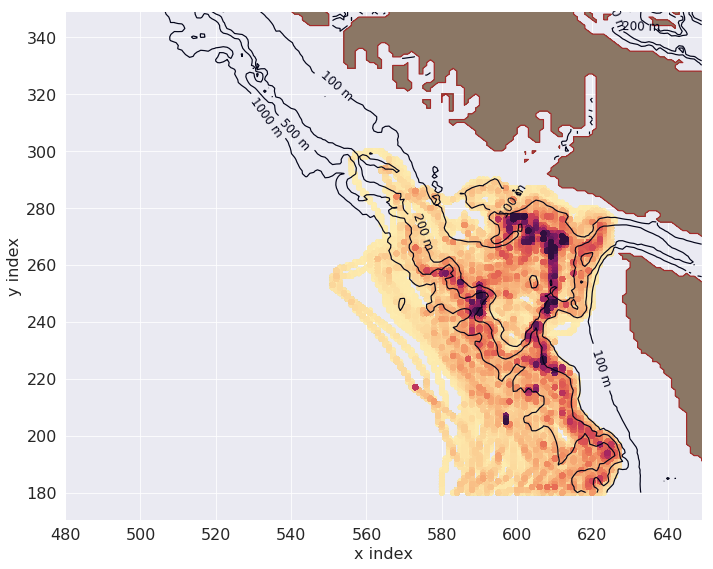

In [19]:
#     cmap=plt.cm.get_cmap('nipy_spectral')
# cmap = plt.cm.get_cmap('Blues_r')
cmap = cmo.cm.matter
cmap.set_bad('#8b7765')


vmin = 0
vmax = 700

import matplotlib as mpl
    


fig, ax = plt.subplots(1, 1, figsize=(10,8)); ax.grid()


CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


# part = ind[0]
# for part in ind[139]:

    
# track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')

    
q = density_scatter(x_plot_cuc, y_plot_cuc, ax= ax, bins = [500,500], cmap = cmap , vmin = vmin, vmax = vmax)
    #     q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

#     t = np.int(np.rint(120 - traj_time[k,part]*120))
#     level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



#     j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
#                                               lon_small,lat_small,grid='NEMO',tols=\
#                                               {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
#                                                'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


#     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
#     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
# #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
# ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


# ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

ax.grid()

# cbar = fig.colorbar(q, ax=ax)
# cbar.set_label(label='Depth ($m$)', fontsize = 16)
# cbar.ax.tick_params(labelsize=16)
fig.tight_layout()

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


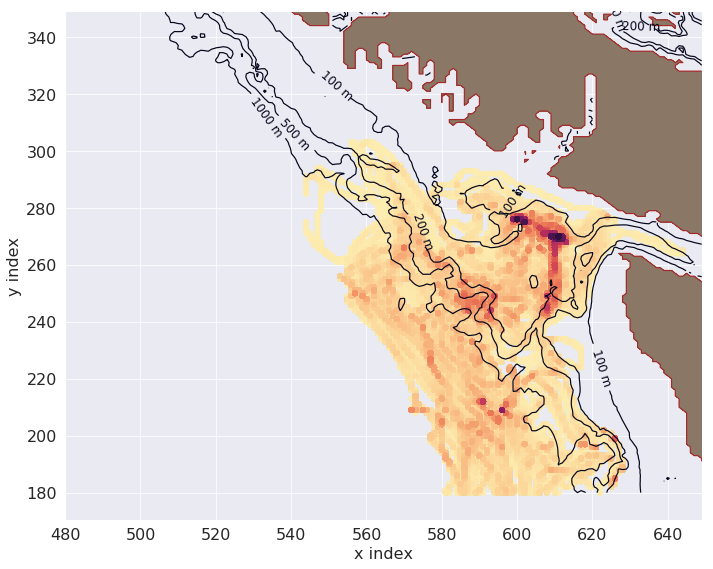

In [20]:
#     cmap=plt.cm.get_cmap('nipy_spectral')
# cmap = plt.cm.get_cmap('Blues_r')
cmap = cmo.cm.matter
cmap.set_bad('#8b7765')


vmin = 0
vmax = 700

import matplotlib as mpl
    


fig, ax = plt.subplots(1, 1, figsize=(10,8)); ax.grid()


CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


# part = ind[0]
# for part in ind[139]:

    
# track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')

    
q = density_scatter(x_plot_south, y_plot_south, ax= ax, bins = [500,500], cmap = cmap , vmin = vmin, vmax = vmax)
    #     q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

#     t = np.int(np.rint(120 - traj_time[k,part]*120))
#     level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



#     j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
#                                               lon_small,lat_small,grid='NEMO',tols=\
#                                               {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
#                                                'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


#     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
#     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
# #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
# ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


# ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

ax.grid()

# cbar = fig.colorbar(q, ax=ax)
# cbar.set_label(label='Depth ($m$)', fontsize = 16)
# cbar.ax.tick_params(labelsize=16)
fig.tight_layout()

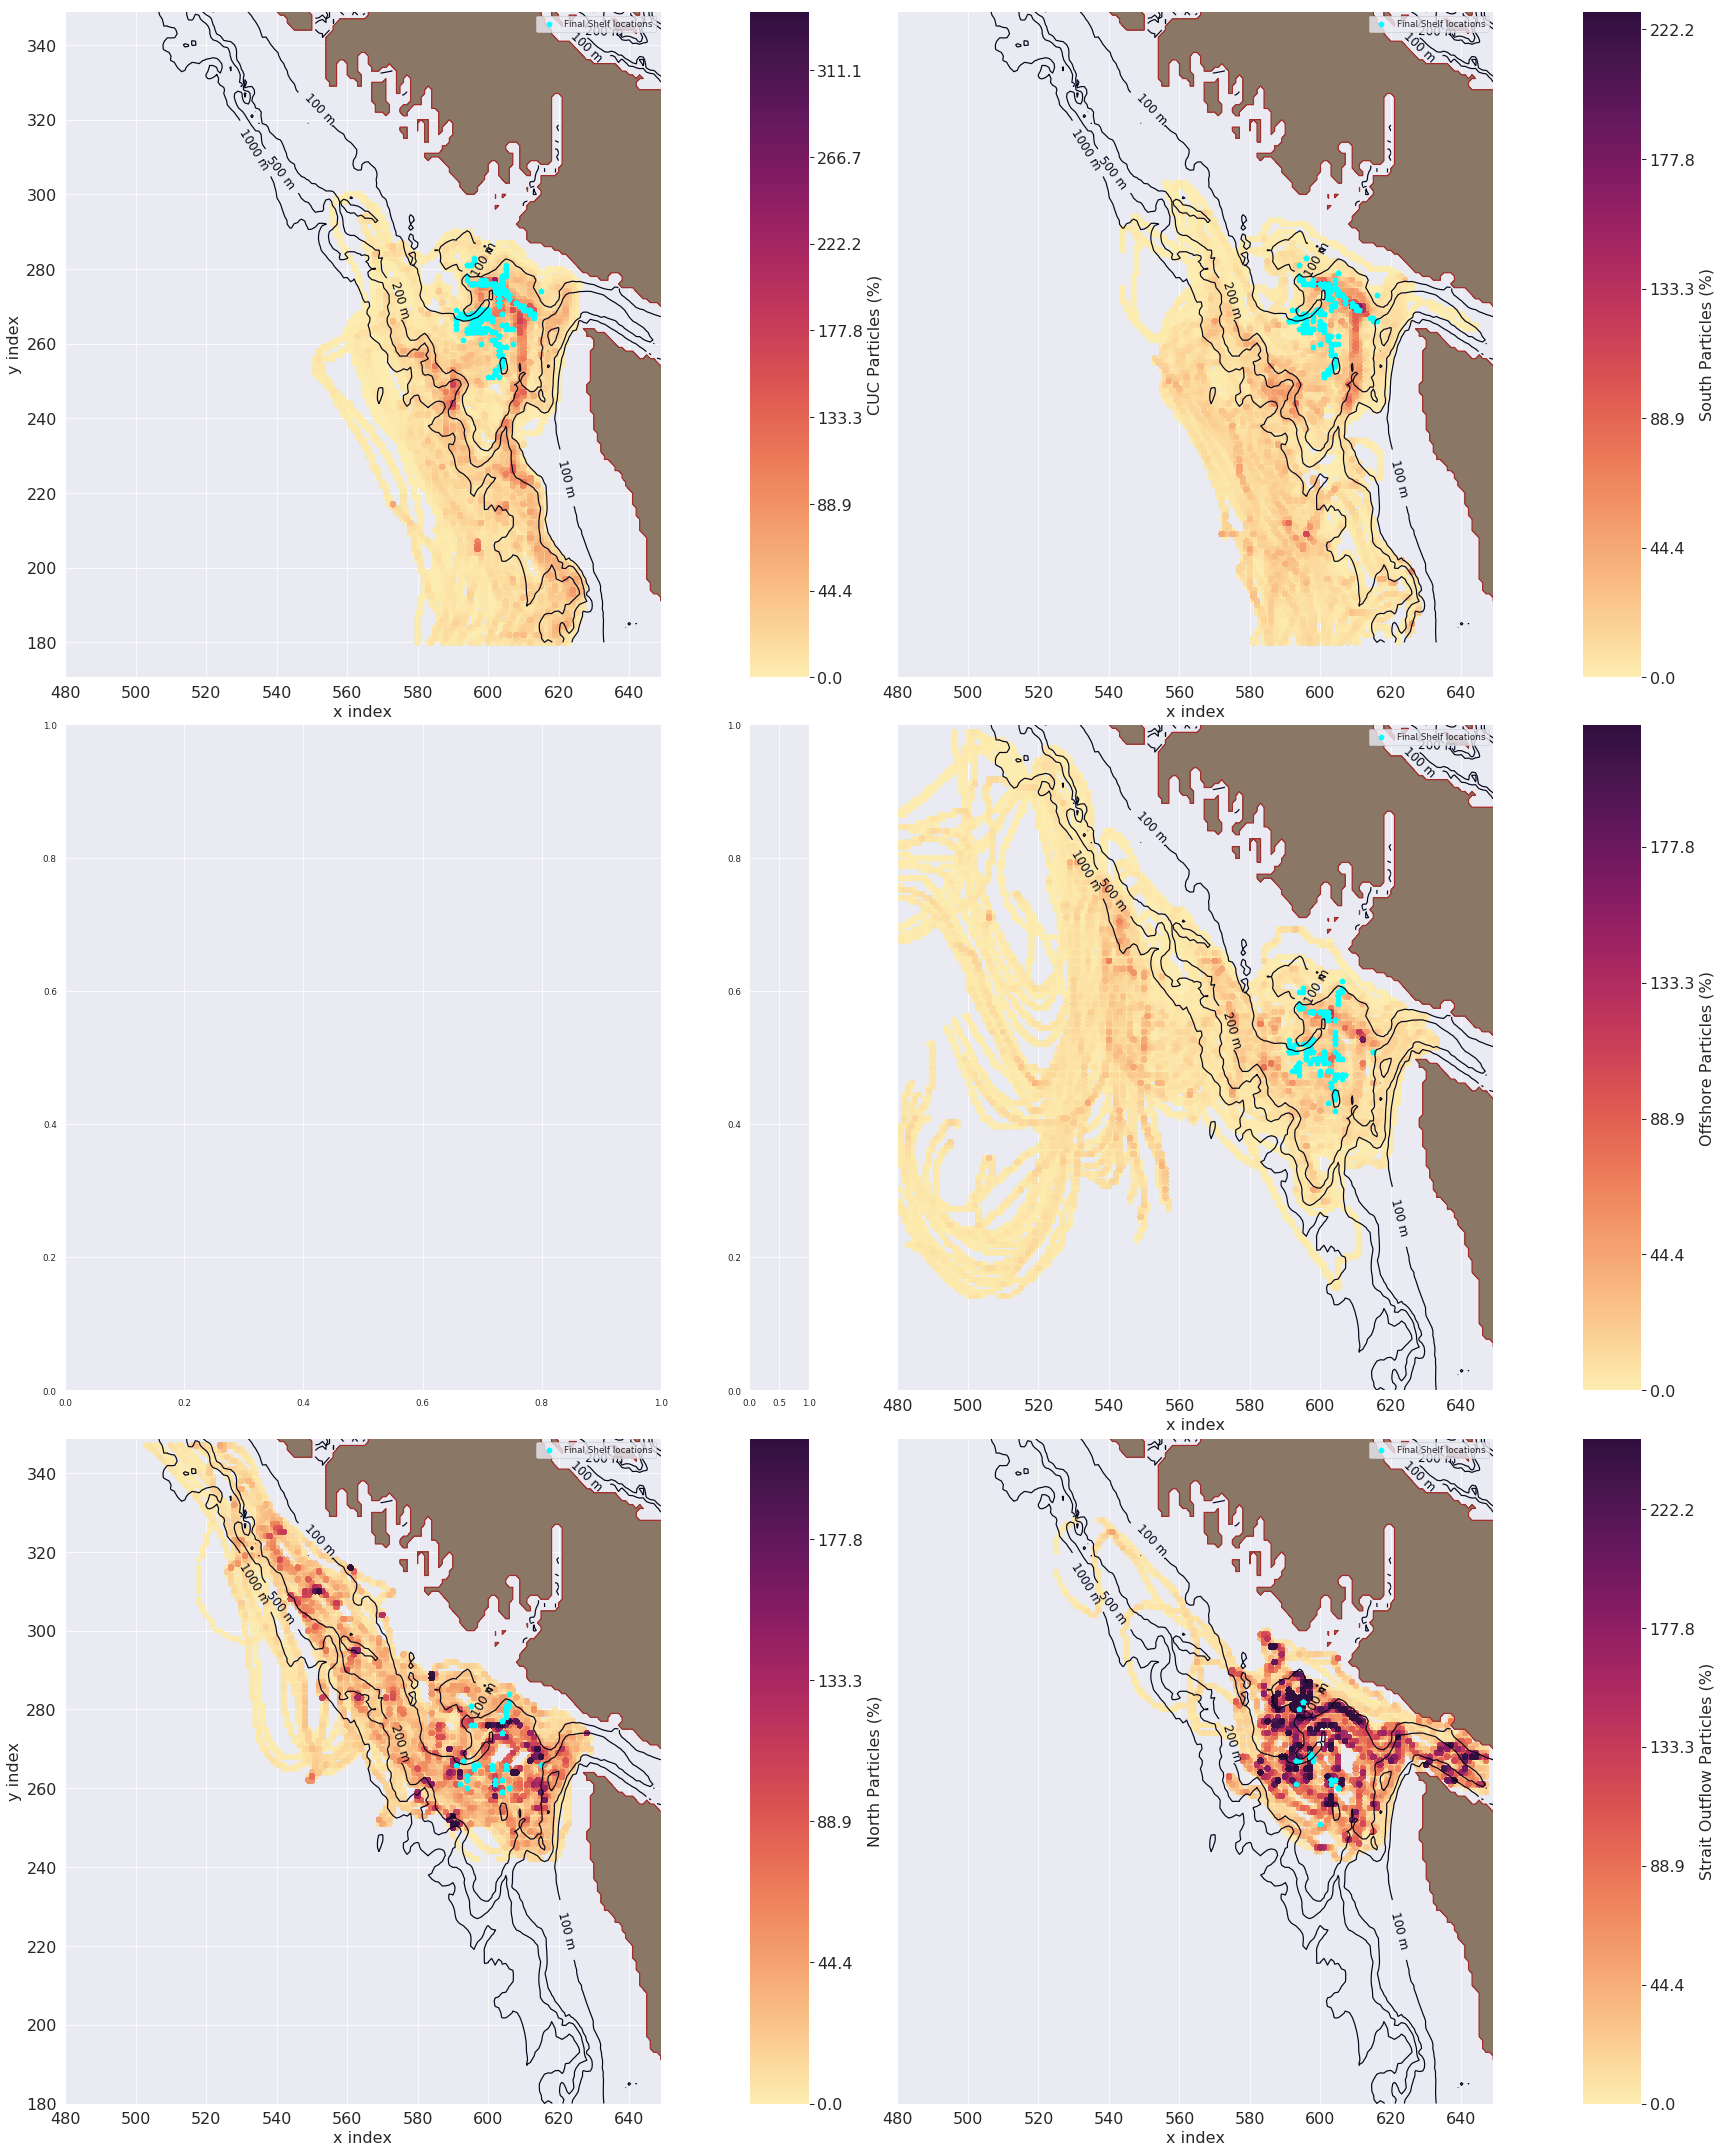

In [21]:
#     cmap=plt.cm.get_cmap('nipy_spectral')
# cmap = plt.cm.get_cmap('Blues_r')
cmap = cmo.cm.matter
cmap.set_bad('#8b7765')




import matplotlib as mpl
    


gridspec = {'width_ratios': [1, 0.1, 1, 0.1]}

fig, (ax, ax1, ax2) = plt.subplots(3, 4, figsize=(24, 30), gridspec_kw=gridspec)


#For CUC 

vmin = 0
vmax = cuc_ind.shape[0]*4

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



    
q = density_scatter(x_plot_cuc, y_plot_cuc, ax= ax[0], bins = [500,500], cmap = cmap , vmin = vmin, vmax = vmax)

ax[0].set_xlabel('x index', fontsize =16)
ax[0].set_ylabel('y index', fontsize = 16)
ax[0].tick_params(axis='both',labelsize =16)

ax[0].scatter(x_wcvi_slice[x1[cuc_ind[:].astype(int)].astype(int)-1],y_wcvi_slice[y1[cuc_ind[:].astype(int)-1].astype(int)-1], \
           marker = '*', c = 'cyan', \
           s = 10, linewidths=3, label = 'Final Shelf locations')

ax[0].legend(loc = 'best')

viz_tools.plot_land_mask(ax[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

# ax[0].grid()

m = cm.ScalarMappable(cmap=cmap)
m.set_array(q)
m.set_clim(vmin,vmax)

cbar = fig.colorbar(m, cax=ax[1])


cbar.ax.set_yticklabels(np.around(a=np.linspace(start=(cbar.vmin/cuc_ind.shape[0])*100, \
                                    stop=(cbar.vmax/cuc_ind.shape[0])*100, num=10), decimals = 1))

cbar.set_label(label='CUC Particles (%)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)

#For South Particles

vmin = 0
vmax = south_ind.shape[0]*4

CS1 = ax[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



    
q = density_scatter(x_plot_south, y_plot_south, ax= ax[2], bins = [500,500], cmap = cmap , vmin = vmin, vmax = vmax)

ax[2].set_xlabel('x index', fontsize =16)
# ax[2].set_ylabel('y index', fontsize = 16)
ax[2].tick_params(axis='both',labelsize =16)
ax[2].get_yaxis().set_ticks([])

ax[2].scatter(x_wcvi_slice[x1[south_ind[:].astype(int)].astype(int)-1],y_wcvi_slice[y1[south_ind[:].astype(int)-1].astype(int)-1], \
           marker = '*', c = 'cyan', \
           s = 10, linewidths=3, label = 'Final Shelf locations')

ax[2].legend(loc = 'best')

viz_tools.plot_land_mask(ax[2], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax[2], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

# ax[0].grid()

m = cm.ScalarMappable(cmap=cmap)
m.set_array(q)
m.set_clim(vmin,vmax)

cbar = fig.colorbar(m, cax=ax[3])


cbar.ax.set_yticklabels(np.around(a=np.linspace(start=(cbar.vmin/south_ind.shape[0])*100, \
                                    stop=(cbar.vmax/south_ind.shape[0])*100, num=10), decimals = 1))

cbar.set_label(label='South Particles (%)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)


# #For local

# vmin = 0
# vmax = ind_local.shape[0]*4

# CS1 = ax1[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

# CS1 = ax1[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

# CS1 = ax1[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

# CS1 = ax1[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



    
# q = density_scatter(x_plot_local, y_plot_local, ax= ax1[0], bins = [500,500], cmap = cmap , vmin = vmin, vmax = vmax)

# ax1[0].set_xlabel('x index', fontsize =16)
# ax1[0].set_ylabel('y index', fontsize = 16)
# ax1[0].tick_params(axis='both',labelsize =16)

# ax1[0].scatter(x_wcvi_slice[x1[ind_local[:].astype(int)].astype(int)-1],y_wcvi_slice[y1[ind_local[:].astype(int)-1].astype(int)-1], \
#            marker = '*', c = 'cyan', \
#            s = 10, linewidths=3, label = 'Final Shelf locations')

# ax1[0].legend(loc = 'best')

# viz_tools.plot_land_mask(ax1[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
# viz_tools.plot_coastline(ax1[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

# # ax[0].grid()

# m = cm.ScalarMappable(cmap=cmap)
# m.set_array(q)
# m.set_clim(vmin,vmax)

# cbar = fig.colorbar(m, cax=ax1[1])


# cbar.ax.set_yticklabels(np.around(a=np.linspace(start=(cbar.vmin/ind_local.shape[0])*100, \
#                                     stop=(cbar.vmax/ind_local.shape[0])*100, num=10), decimals = 1))

# cbar.set_label(label='Local Particles (%)', fontsize = 16)
# cbar.ax.tick_params(labelsize=16)

#For Offshore Particles

vmin = 0
vmax = off_ind.shape[0]*4

CS1 = ax1[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax1[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax1[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax1[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



    
q = density_scatter(x_plot_off, y_plot_off, ax= ax1[2], bins = [500,500], cmap = cmap , vmin = vmin, vmax = vmax)

ax1[2].set_xlabel('x index', fontsize =16)
# ax1[2].set_ylabel('y index', fontsize = 16)
ax1[2].tick_params(axis='both',labelsize =16)
ax1[2].get_yaxis().set_ticks([])

ax1[2].scatter(x_wcvi_slice[x1[off_ind[:].astype(int)].astype(int)-1],y_wcvi_slice[y1[off_ind[:].astype(int)-1].astype(int)-1], \
           marker = '*', c = 'cyan', \
           s = 10, linewidths=3, label = 'Final Shelf locations')

ax1[2].legend(loc = 'best')
ax1[2].set_xlim(left = 480)

viz_tools.plot_land_mask(ax1[2], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax1[2], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

# ax[0].grid()

m = cm.ScalarMappable(cmap=cmap)
m.set_array(q)
m.set_clim(vmin,vmax)

cbar = fig.colorbar(m, cax=ax1[3])


cbar.ax.set_yticklabels(np.around(a=np.linspace(start=(cbar.vmin/off_ind.shape[0])*100, \
                                    stop=(cbar.vmax/off_ind.shape[0])*100, num=10), decimals = 1))

cbar.set_label(label='Offshore Particles (%)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)

#For north particles

vmin = 0
vmax = north_ind.shape[0]*4

CS1 = ax2[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax2[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax2[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax2[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



    
q = density_scatter(x_plot_north, y_plot_north, ax= ax2[0], bins = [500,500], cmap = cmap , vmin = vmin, vmax = vmax)

ax2[0].set_xlabel('x index', fontsize =16)
ax2[0].set_ylabel('y index', fontsize = 16)
ax2[0].tick_params(axis='both',labelsize =16)

ax2[0].scatter(x_wcvi_slice[x1[north_ind[:].astype(int)].astype(int)-1],y_wcvi_slice[y1[north_ind[:].astype(int)-1].astype(int)-1], \
           marker = '*', c = 'cyan', \
           s = 10, linewidths=3, label = 'Final Shelf locations')

ax2[0].legend(loc = 'best')

viz_tools.plot_land_mask(ax2[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax2[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

# ax[0].grid()

m = cm.ScalarMappable(cmap=cmap)
m.set_array(q)
m.set_clim(vmin,vmax)

cbar = fig.colorbar(m, cax=ax2[1])


cbar.ax.set_yticklabels(np.around(a=np.linspace(start=(cbar.vmin/north_ind.shape[0])*100, \
                                    stop=(cbar.vmax/north_ind.shape[0])*100, num=10), decimals = 1))

cbar.set_label(label='North Particles (%)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)

#For Juan Particles

vmin = 0
vmax = juan_ind.shape[0]*4

CS1 = ax2[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax2[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax2[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax2[2].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



    
q = density_scatter(x_plot_juan, y_plot_juan, ax= ax2[2], bins = [500,500], cmap = cmap , vmin = vmin, vmax = vmax)

ax2[2].set_xlabel('x index', fontsize =16)
# ax2[2].set_ylabel('y index', fontsize = 16)
ax2[2].tick_params(axis='both',labelsize =16)
ax2[2].get_yaxis().set_ticks([])

ax2[2].scatter(x_wcvi_slice[x1[juan_ind[:].astype(int)].astype(int)-1],y_wcvi_slice[y1[juan_ind[:].astype(int)-1].astype(int)-1], \
           marker = '*', c = 'cyan', \
           s = 10, linewidths=3, label = 'Final Shelf locations')

ax2[2].legend(loc = 'best')

viz_tools.plot_land_mask(ax2[2], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='#8b7765')
viz_tools.plot_coastline(ax2[2], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

# ax[0].grid()

m = cm.ScalarMappable(cmap=cmap)
m.set_array(q)
m.set_clim(vmin,vmax)

cbar = fig.colorbar(m, cax=ax2[3])


cbar.ax.set_yticklabels(np.around(a=np.linspace(start=(cbar.vmin/juan_ind.shape[0])*100, \
                                    stop=(cbar.vmax/juan_ind.shape[0])*100, num=10), decimals = 1))

cbar.set_label(label='Strait Outflow Particles (%)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)


# fig.tight_layout(w_pad=0.05)

fig.tight_layout(h_pad=0.01,w_pad=0.01)